In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import os.path
from pathlib import Path
import pickle
import math

In [2]:
imageHeight = 480
imageWidth = 640

# Process

1. detect feature points

2. make (train) dictionary of feature points (reduce the descriptor's dimension)

3. make signature from the dictionary

4. loop closure detection

## test of SURF detection

the dimension of surf points is : 64
number of points detected is : 343


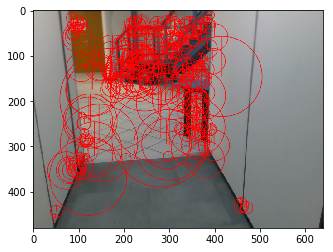

In [3]:
i = 0
image = np.load('F:/pfe_2/realsense/frames/rgb/'+str(i).zfill(3)+'.npy')
image = cv2.resize(image, (imageWidth, imageHeight))
surf = cv2.xfeatures2d.SURF_create(400, upright=1)
print('the dimension of surf points is :', surf.descriptorSize() )
kp, des = surf.detectAndCompute(image,None)
print('number of points detected is :', len(kp))
img2 = cv2.drawKeypoints(image,kp,None,(255,0,0),4)
plt.imshow(img2)

## test of SURF detection with FREAK extractor

####  FREAK : Fast Retina Keypoint
faster and rebuster than sift surf
https://infoscience.epfl.ch/record/175537/files/2069.pdf

the size of surf points is : 381
length after FREAK is :  201


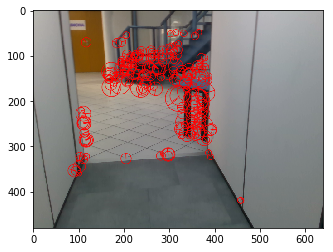

In [41]:
surf = cv2.xfeatures2d.SURF_create(300)
keypoints_s = surf.detect(image,None)

freakExtractor = cv2.xfeatures2d.FREAK_create()
keypoints,descriptors= freakExtractor.compute(image,keypoints_s)
img2 = cv2.drawKeypoints(image,keypoints,None,(255,0,0),4)
print('the size of surf points is :', len(keypoints_s))
print('length after FREAK is : ',len(keypoints))
plt.imshow(img2)

In [13]:
## detecte SURF feature points, maximum number : num(default:400)
def feature_points_detection(image, num=400):
    image = cv2.resize(image, (imageWidth, imageHeight))
    surf = cv2.xfeatures2d.SURF_create(300, upright=1)
    kp, des = surf.detectAndCompute(image,None)
    num = np.min((num, len(kp)))
    return kp[0:num], des[0:num]

## make signature of image (bag of words)

### 1. train the bag of words

In [105]:
def train_bow_extract(FileList, surf):
    BOW = cv2.BOWKMeansTrainer(100)
    for ImageName in FileList:
        img = np.load(ImageName)
        kp, des = surf.detectAndCompute(img,None)
        BOW.add(des)
    dictionary = BOW.cluster()
    
    np.save('dictionary.npy', dictionary)
    print(' --- train success, dictionary saved')
    return 0

In [103]:
# test train with about 20 images
surf = cv2.xfeatures2d.SURF_create(300, extended = False)
matcher = cv2.BFMatcher(cv2.NORM_L2)

FileList = glob.glob('F:/pfe_2/realsense/frames/rgb/*.npy')
bow_extract = train_bow_extract(FileList, surf)
dictionary = np.load('dictionary.npy')
bow_extract = cv2.BOWImgDescriptorExtractor(surf, matcher ) 
bow_extract.setVocabulary( dictionary )

### 2. test

In [88]:
img1 = np.load('F:/pfe_2/realsense/frames/rgb/001.npy')
img2 = np.load('F:/pfe_2/realsense/frames/rgb/002.npy')
img3 = np.load('F:/pfe_2/realsense/frames/rgb/010.npy')

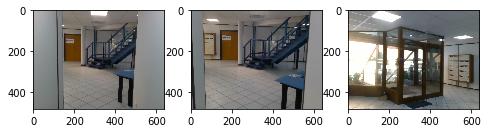

In [82]:
plt.figure(figsize = (8,5))
plt.subplot(131); plt.imshow(img1)
plt.subplot(132); plt.imshow(img2)
plt.subplot(133); plt.imshow(img3)

In [77]:
def get_signature(bow_extract, detection ,  image):
    kp = detection.detect(image)
    kp, des = detection.compute(image,kp)
    inp = bow_extract.compute(image,kp)
    return inp

In [96]:
inp1 = get_signature(bow_extract, surf , img1)
inp2 = get_signature(bow_extract, surf , img2)
inp3 = get_signature(bow_extract, surf , img3)
print('the norm of distance of signature of image1 and image2 is :', 
      np.linalg.norm(inp1-inp2))
print('the norm of distance of signature of image1 and image3 is :', 
      np.linalg.norm(inp1-inp3))
print('the norm of distance of signature of image2 and image3 is :', 
      np.linalg.norm(inp2-inp3))

the norm of distance of signature of image1 and image2 is : 0.06338152
the norm of distance of signature of image1 and image3 is : 0.12168523
the norm of distance of signature of image2 and image3 is : 0.089194655


## Loop closure detection

In [98]:
# init
surf = cv2.xfeatures2d.SURF_create(300, extended = False)
matcher = cv2.BFMatcher(cv2.NORM_L2)

# train
FileList = glob.glob('F:/pfe_2/realsense/frames/rgb/*.npy')
bow_extract = train_bow_extract(FileList, surf)

# load
dictionary = np.load('dictionary.npy')
bow_extract = cv2.BOWImgDescriptorExtractor(surf, matcher ) 
bow_extract.setVocabulary( dictionary )

In [126]:
def loop_closure_detection(inp_image, image_num,filedict, threshold=0.08):
    if Path(filedict).exists():
        with open(filedict, 'rb') as f:
            image_signatures = pickle.load(f)
    else: 
        image_signatures = []
    detected = False
    num = []
    for sign in image_signatures:
        dis = np.linalg.norm(sign["inp"]-inp_image)
        if dis < threshold:
            detected = True
            num.append(sign["num"])
            
    if not detected:
        sign = {}
        sign["inp"] = inp_image
        sign["num"] = image_num
        image_signatures.append(sign)
        with open(filedict, 'wb') as f:
            pickle.dump(image_signatures, f)
        return detected, num
    else: 
        return detected, num

![title](img/4.PNG)

In [134]:
filedict = 'loop_closure_dict.pickle'
for i in range(32):
    image = np.load('F:/pfe_2/realsense/frames/rgb/'+str(i).zfill(3)+'.npy')
    inp = get_signature(bow_extract, surf , image)
    
    d, n = loop_closure_detection(inp, i, filedict, threshold=0.08)
    print(i,'if detected loop:', d, ',   if true with image num: ',n )

0 if detected loop: False ,   if true with image num:  []
1 if detected loop: True ,   if true with image num:  [0]
2 if detected loop: True ,   if true with image num:  [0]
3 if detected loop: False ,   if true with image num:  []
4 if detected loop: True ,   if true with image num:  [3]
5 if detected loop: False ,   if true with image num:  []
6 if detected loop: False ,   if true with image num:  []
7 if detected loop: True ,   if true with image num:  [3, 5]
8 if detected loop: True ,   if true with image num:  [3]
9 if detected loop: False ,   if true with image num:  []
10 if detected loop: True ,   if true with image num:  [9]
11 if detected loop: False ,   if true with image num:  []
12 if detected loop: False ,   if true with image num:  []
13 if detected loop: False ,   if true with image num:  []
14 if detected loop: True ,   if true with image num:  [11, 13]
15 if detected loop: True ,   if true with image num:  [9]
16 if detected loop: True ,   if true with image num:  [3]

## refine the matrixes by loop closure

In [7]:
## we need T(i)
## need save mtx

In [2]:
# calculate the trans matrix between two image
def matrix(file, idx1, idx2):
    mtx = np.load(file + '/mtx.npy')
    image1 = np.load(file + '/rgb/'+str(idx1).zfill(3)+'.npy')
    depth1 = np.load(file + '/d/'+str(idx1).zfill(3)+'.npy')
    image2 = np.load(file + '/rgb/'+str(idx2).zfill(3)+'.npy')
    depth2 = np.load(file + '/d/'+str(idx2).zfill(3)+'.npy')
    pts1, pts2 = feature_points_detection_and_matching(image1, image2)
    pts1, pts2 = delete_no_depth_points(pts1, pts2, depth1, depth2, mtx)
    return rigid_transform_3D(pts1, pts2)

In [4]:
def trans_matrix(r,t):
    # T (ki to t), rotate and transport matrix
    r = r.ravel()
    t = t.ravel()
    (a,b,c) = (r[0], r[1], r[2])
    (x,y,z) = (t[0], t[1], t[2])
    Rz = np.matrix([[1,0,0],
          [0, np.cos(a), -np.sin(a)],
         [0, np.sin(a), np.cos(a)]])
    Ry = np.matrix([[np.cos(b), 0 , np.sin(b)],
          [0 , 1, 0],
          [-np.sin(b), 0 , np.cos(b)]])
    Rx = np.matrix([[np.cos(c), -np.sin(c), 0],
         [np.sin(c), np.cos(c), 0],
         [0,0,1]])
    R = np.dot(Rz,np.dot(Ry,Rx))
    T = np.concatenate((R, np.matrix([[x],[y],[z]])), axis=1)
    return T

In [5]:
def factor_average_T(T1, factor1, T2, factor2):
    t1 = T1[0:3,3]
    dst1, _ = cv2.Rodrigues(T1[0:3,0:3])

    t2 = T2[0:3,3]
    dst2, _ = cv2.Rodrigues(T2[0:3,0:3])
    
    t = (factor1*t1 + factor2*t2)/(factor1+factor2)
    dst = (factor1*dst1 + factor2*dst2)/(factor1+factor2)
    return trans_matrix(dst, t)

In [6]:
# refine the matrixes from refined_idx to current_idx
# as the target_idx as refernece
def refine_map_with_loop_closure(current_idx, taget_idx, refined_idx, matrix_file, data_file):
    for i in range(current_idx - refined_idx):
        idx = current_idx - i
        T_old = np.load(matrix_file + '/' + str(idx).zfill(3) + '.npy')
        if i == 0:
            T_new = matrix(data_file, taget_idx, idx)
        else:
            T_temp = matrix(data_file, idx+1, idx)
            T_new = matrix_multi(T_temp, T_new)
        T_final = factor_average_T(T_new, (current_idx - refined_idx-i) , T_old, i)
        np.save(matrix_file + '/' + str(idx).zfill(3) + '.npy', T_final)
    refined_idx = current_idx
    return refined_idx  

In [ ]:
# get ply file from several(num) rgbd images

def ply_for_n_images(num, start, mtx, filedict):
    image1 = np.load('F:/pfe_2/realsense/frames/rgb/'+str(start).zfill(3)+'.npy')
    depth1 = np.load('F:/pfe_2/realsense/frames/d/'+str(start).zfill(3)+'.npy')
    M_rigid_old = np.eye(3,4)
    res1 = vert_new(image1,depth1, M_rigid_old, mtx)
    write_ply('test0.ply', res1)
    for i in range(num):
        image2 = np.load('F:/pfe_2/realsense/frames/rgb/'+str(start+i+1).zfill(3)+'.npy')
        depth2 = np.load('F:/pfe_2/realsense/frames/d/'+str(start+i+1).zfill(3)+'.npy')
        pts1, pts2 = feature_points_detection_and_matching(image1, image2,param =0.55)
        pts1, pts2 = delete_no_depth_points(pts1, pts2, depth1, depth2, mtx)
        #retval, M_cv, inliers = cv2.estimateAffine3D(pts2, pts1, ransacThreshold=12)
        #pts1 = get_inliers_pts(pts1, inliers)
        #pts2 = get_inliers_pts(pts2, inliers)
        M_rigid_new = rigid_transform_3D(pts1, pts2)
        M_rigid_old = matrix_multi(M_rigid_new, M_rigid_old)
        np.save('Ms/' + str(start+i+1).zfill(3) + '.npy', M_rigid_old)
        
        d, n = loop_closure_detection(inp_image, start+i+1 ,filedict, threshold=0.08)
        # res1 = vert_new(image2,depth2, M_rigid_old, mtx, True)
        # print('  drawn one image')
        # write_ply('test'+str(i+1)+'.ply', res1)
        image1 = image2
        depth1 = depth2
    print('----- finished -----')
    return 0

In [ ]:
filedict = 'loop_closure_dict.pickle'

## Closing loop

linear pose interpolation between two pose, according to its disantance to where the loop was detected.

In [11]:
def slerp(v0, v1, t_array):
    #  calculate multiple slerp interpolations between the two quaternions.
    # in wikipedia https://en.wikipedia.org/wiki/Slerp
    t_array = np.array(t_array)
    v0 = np.array(v0)
    v1 = np.array(v1)
    dot = np.sum(v0*v1)

    if (dot < 0.0):
        v1 = -v1
        dot = -dot
    
    DOT_THRESHOLD = 0.9995
    if (dot > DOT_THRESHOLD):
        result = v0[np.newaxis,:] + t_array[:,np.newaxis]*(v1 - v0)[np.newaxis,:]
        result = result/np.linalg.norm(result)
        return result
    
    theta_0 = np.arccos(dot)
    sin_theta_0 = np.sin(theta_0)

    theta = theta_0*t_array
    sin_theta = np.sin(theta)
    
    s0 = np.cos(theta) - dot * sin_theta / sin_theta_0
    s1 = sin_theta / sin_theta_0
    return (s0[:,np.newaxis] * v0[np.newaxis,:]) + (s1[:,np.newaxis] * v1[np.newaxis,:])

def quaternion_to_euler_angle(w, x, y, z):
    ysqr = y * y
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + ysqr)
    X = math.degrees(math.atan2(t0, t1))
    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.degrees(math.asin(t2)) 
    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (ysqr + z * z)
    Z = math.degrees(math.atan2(t3, t4))
    return X, Y, Z

def euler_angle_to_quaternion(pitch, roll, yaw):
    cy = np.cos(yaw * 0.5)
    sy = np.sin(yaw * 0.5)
    cr = np.cos(roll * 0.5)
    sr = np.sin(roll * 0.5)
    cp = np.cos(pitch * 0.5)
    sp = np.sin(pitch * 0.5)
    
    w = cy*cr*cp + sy*sr*sp
    x = cy*sr*cp - sy*cr*sp
    y = cy*cr*sp + sy*sr*cp
    z = sy*cr*cp - cy*sr*sp
    return w, x, y, z

In [29]:
def matrix_interpolate(T0, T1, t):
    dis0 = T0[0:3,3]
    dst0, _ = cv2.Rodrigues(T0[0:3,0:3])
    quaternion0 = euler_angle_to_quaternion(dst0[0], dst0[1], dst0[2])
    dis1 = T1[0:3,3]
    dst1, _ = cv2.Rodrigues(T1[0:3,0:3])
    quaternion1 = euler_angle_to_quaternion(dst1[0], dst1[1], dst1[2])
    
    dis = slerp(dis0, dis1, [t])[0]
    quaternion = slerp(quaternion0, quaternion1, [t])[0]
    dst = quaternion_to_euler_angle(quaternion[0], quaternion[1], quaternion[2], quaternion[3])
    
    T0[0:3,0:3] = cv2.Rodrigues(dst)[0]
    T0[0:3,3] = dis
    return T0

In [38]:

matrix_interpolate(np.eye(3,4), np.eye(3,4)+1, 0.0)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])